## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

## <span style="color:darkred">Avaliação Final</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `creditcard.csv` que contém 31 colunas. Esse problema é o de detectar fraude em transações em cartões de crédito. Vamos assumir um cenário com alta disponibilidade de exemplos não rotulados, e baixa de exemplos rotulados. Para tal, pré-treinaremos camadas de uma rede neural com dados não anotados, a qual posteriormente será usada para compor um modelo inicial de classificação.<br><br>

<font color="blue">
Você deverá criar um notebook (ipynb) com a solução. O Notebook deverá conter as saídas para visualização dos resultados. Fazer upload no Moodle de 2 arquivos:</font>

<font color="blue">1. Notebook com o código fonte (ipynb)</font><br>
<font color="blue">2. Versão em PDF com todos os resultados</font>

Conforme código abaixo, use como características de entrada as colunas de posição 1 até 28 (marcadas no arquivo como V1 - V28), e como classe a última coluna (Class). Não utilize a coluna Amount.

As tarefas a realizar são as seguintes:

1. **Separe** os dados em:
    * conjunto S = 2,5% dos dados iniciais como treinamento com rótulo (assumiremos que temos rótulos apenas para esses 2,5%, ou 7120 exemplos), no formato par (x,y)
    * conjunto U = 50% dos dados iniciais como treinamento não anotado (note que S está contido em U), 
    * conjunto T = o restante dos 50% para teste, no formato par (x,y).<br><br>
1. **Modelo A**: denoising overcomplete autoencoder para pré-treinamento baseado em auto-supervisão
    * Arquitetura com as seguintes camadas:
        * entrada com 28 valores
        * normalização em batch
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * dropout 0.2
        * normalização em batch
        * densa 28 neurônios, relu (camada de código/bottleneck)
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * densa 28 neurônios, tanh
    * Inserção de ruído aleatório uniforme ponderado a 0.2 (insira ruído nos dados de treinamento fornecidos por entrada, mas mantenha a comparação com a saída sem ruído, como num denoising autoencoder)
    * Taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
    * Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto **U**<br><br>
1. **Análise de projeção das características**: visualize um scatterplot com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes:
    * scatterplot com projeção PCA do conjunto de S original
    * scatterplot com projeção PCA do conjunto S após processado pelo "encoder", ou seja resultado da saída da camada de código<br><br>
    
1. **Modelo B**: rede neural profunda densa, utilizando como base o encoder do modelo A, e inserindo uma nova camada densa de classificação com ativação sigmóide.<br>
    * Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
    * Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
    * Treinar com perda MSE por 8 épocas com batch size 16 
    * Compute como métricas, além da perda, precisão e revocação (precision / recall)<br><br>
    
1. **Avalie a rede neural de classificação**: 
    * Exiba o gráfico da precisão e revocação no treinamento calculada ao longo das épocas
    * Exiba precisão e revocação calculada no treinamento S e teste T
    * Exiba um scatterplot do conjunto S obtendo sua representação do código da rede de classificação (saída da camada com 28 exemplos)<br><br>

1. **Bônus:** (+1 ponto extra) compare a solução com duas outras possibilidades que não envolvam uso do conjunto **U** não rotulado
    * Rede neural profunda com a mesma arquitetura e estratégias usadas no modelo B, mas sem usar os pesos pré-treinados, inicializando e treinando com os dados em S por 15 épocas. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados originais S. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados S obtendo sua representação do código da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pandas as pd
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Parte 1: separar dados

In [3]:
X = df.drop(
    ['Time', 'Amount', 'Class'],
    axis = 1
    ).copy()
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [4]:
Y = df[ ['Class'] ].copy()
Y.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [5]:
n = Y['Class'].count()
n

284807

In [6]:
#### Separando os conjuntos após filtragem dos atributos
S = (X.iloc[ : 7120].copy(), Y.iloc[ : 7120].copy())

print(f'({len(S[0])}, {len(S[1])})')

(7120, 7120)


In [7]:
U = (X.iloc[ : int(n/2)].copy(), Y.iloc[ : int(n/2)].copy())

print(f'({len(U[0])}, {len(U[1])})')

(142403, 142403)


In [8]:
T = (X.iloc[int(n/2) : ].copy(), Y.iloc[int(n/2) : ].copy())

print(f'({len(T[0])}, {len(T[1])})')

(142404, 142404)


### Parte 2: Modelo A

#### denoising overcomplete autoencoder para pré-treinamento baseado em auto-supervisão

In [9]:
#Inicializando as sementes
seed(1)
set_seed(2)

In [10]:
# entrada com 28 valores
input_data = keras.layers.Input(
    shape=(28)
    )
# normalização em batch
x = keras.layers.BatchNormalization()(input_data)
# densa 32 neurônios, relu
x = keras.layers.Dense(
    32, activation='relu'
    )(x)
# densa 32 neurônios, relu
x = keras.layers.Dense(
    32, activation='relu'
    )(x)
# dropout 0.2
x = keras.layers.Dropout(
    0.2
    )(x)
# normalização em batch
x = keras.layers.BatchNormalization()(x)
# densa 28 neurônios, relu (camada de código/bottleneck)
x = keras.layers.Dense(
    28, activation='relu', name='code'
    )(x)
# densa 32 neurônios, relu
x = keras.layers.Dense(
    32, activation='relu'
    )(x)
# densa 32 neurônios, relu
x = keras.layers.Dense(
    32, activation='relu'
    )(x)
# densa 28 neurônios, tanh
output = keras.layers.Dense(
    28, activation = 'tanh'
    )(x)

model_a = keras.models.Model(
    input_data,
    output
    )

In [11]:
model_a.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [12]:
batch_size = 16
epochs = 20
noise_factor = 0.2

In [13]:
x_train = U[0].astype('float32').values

x_train_noise = x_train + noise_factor * np.random.normal(0, 1, x_train.shape)

In [14]:
# Taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
def scheduler_a(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.2),4)    

In [15]:
callbacklr_a = keras.callbacks.LearningRateScheduler(
    scheduler_a
    )

In [16]:
model_a.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(
        lr = 0.003
        )
    )

In [17]:
hist_a = model_a.fit(
    x = x_train_noise,
    y = x_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ callbacklr_a ],
    verbose = 1
    )

Epoch 1/20
8901/8901 [==============================] - 25s 3ms/step - loss: 0.6189
Epoch 2/20
8901/8901 [==============================] - 24s 3ms/step - loss: 0.5563
Epoch 3/20
8901/8901 [==============================] - 27s 3ms/step - loss: 0.5417
Epoch 4/20
8901/8901 [==============================] - 26s 3ms/step - loss: 0.5364
Epoch 5/20
8901/8901 [==============================] - 27s 3ms/step - loss: 0.5328
Epoch 6/20
8901/8901 [==============================] - 25s 3ms/step - loss: 0.5283
Epoch 7/20
8901/8901 [==============================] - 25s 3ms/step - loss: 0.5235
Epoch 8/20
8901/8901 [==============================] - 28s 3ms/step - loss: 0.5201
Epoch 9/20
8901/8901 [==============================] - 26s 3ms/step - loss: 0.5175
Epoch 10/20
8901/8901 [==============================] - 27s 3ms/step - loss: 0.5158
Epoch 11/20
8901/8901 [==============================] - 24s 3ms/step - loss: 0.5139
Epoch 12/20
8901/8901 [==============================] - 24s 3ms/step - lo

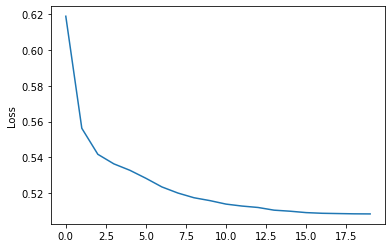

In [18]:
plt.plot(hist_a.history['loss'])
plt.ylabel('Loss')
plt.show()

### Parte 3: Análise da projeção das características

visualize um scatterplot com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes:


In [19]:
from sklearn.decomposition import PCA

In [20]:
x_train = S[0].values
y_train = S[1].values

#### scatterplot com projeção PCA do conjunto de S original

In [21]:
pca = PCA(
    n_components = 2
    )

pca.fit(
    x_train
    )

pca_train = pca.transform(
    x_train
    )

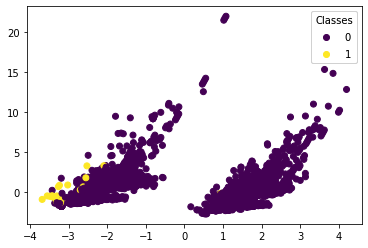

In [22]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    pca_train[:,0], pca_train[:,1], c = y_train[:], cmap='viridis'
    )
legend1 = ax.legend(
    *scatter.legend_elements(), loc='best', title='Classes'
    )
ax.add_artist(legend1)

#### scatterplot com projeção PCA do conjunto S após processado pelo "encoder", ou seja resultado da saída da camada de código

In [23]:
code_model = keras.models.Model(
    inputs = model_a.input,
    outputs = model_a.get_layer('code').output
    )

In [24]:
code_train = np.asarray(
    code_model.predict(
        x_train
        )
    )

In [25]:
pca = PCA(
    n_components = 2
    )

pca.fit(
    code_train
    )

pca_train = pca.transform(
    code_train
    )

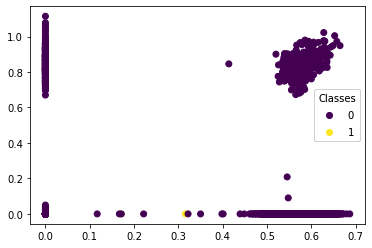

In [26]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    code_train[:,0], code_train[:,1], c = y_train[:], cmap='viridis'
    )
legend1 = ax.legend(
    *scatter.legend_elements(), loc='best', title='Classes'
    )
ax.add_artist(legend1)

### Parte 4: Modelo B

In [27]:
#Inicializando as sementes
seed(1)
set_seed(2)

In [28]:
encoder = keras.models.Model(
    inputs = model_a.input,
    outputs = model_a.get_layer(name = 'code').output
    )

In [29]:
new = keras.models.Sequential()
new.add(
    keras.layers.Dense(
        1,
        activation = 'sigmoid',
        name = 'pred',
        input_shape = encoder.output_shape[1:]
        )
    )

model_b = keras.models.Model(
    inputs = encoder.input,
    outputs = new(encoder.output)
    )

In [30]:
model_b.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [31]:
batch_size = 16
epochs = 8

class_weight = {
    0: 0.1,
    1: 0.9
    }

In [38]:
x_train = U[0].astype('float32').values
y_train = U[1].astype('float32').values

In [39]:
# Taxa de aprendizado inicial de 0.001
# e com decaimento em todas as épocas exponencial a -0.3
def scheduler_b(epoch, lr):
    return np.round(lr * tf.math.exp(-0.3),4)    

In [40]:
callbacklr_b = keras.callbacks.LearningRateScheduler(
    scheduler_b
    )

In [41]:
model_b.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(
        lr = 0.001
        ),
    metrics = [
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
        ]
    )

In [42]:
hist_b = model_b.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ callbacklr_b ],
    class_weight = class_weight,
    verbose = 1
    )

Epoch 1/8
8901/8901 [==============================] - 33s 4ms/step - loss: 9.0355e-04 - precision_1: 0.1884 - recall_1: 0.6654
Epoch 2/8
8901/8901 [==============================] - 35s 4ms/step - loss: 3.6734e-04 - precision_1: 0.7690 - recall_1: 0.7918
Epoch 3/8
8901/8901 [==============================] - 33s 4ms/step - loss: 3.3849e-04 - precision_1: 0.7358 - recall_1: 0.8178
Epoch 4/8
8901/8901 [==============================] - 32s 4ms/step - loss: 3.4313e-04 - precision_1: 0.7821 - recall_1: 0.8141
Epoch 5/8
8901/8901 [==============================] - 33s 4ms/step - loss: 3.3659e-04 - precision_1: 0.7719 - recall_1: 0.8178
Epoch 6/8
8901/8901 [==============================] - 34s 4ms/step - loss: 3.4562e-04 - precision_1: 0.7604 - recall_1: 0.8141
Epoch 7/8
8901/8901 [==============================] - 32s 4ms/step - loss: 3.2865e-04 - precision_1: 0.7762 - recall_1: 0.8253
Epoch 8/8
8901/8901 [==============================] - 32s 4ms/step - loss: 3.2082e-04 - precision_1: 0.

### Parte 5: Avaliação da rede neural de classificação

1. **Avalie a rede neural de classificação**: 
    * Exiba o gráfico da precisão e revocação no treinamento calculada ao longo das épocas
    * Exiba precisão e revocação calculada no treinamento S e teste T
    * Exiba um scatterplot do conjunto S obtendo sua representação do código da rede de classificação (saída da camada com 28 exemplos)<br><br>


#### Exiba o gráfico da precisão e revocação no treinamento calculada ao longo das épocas

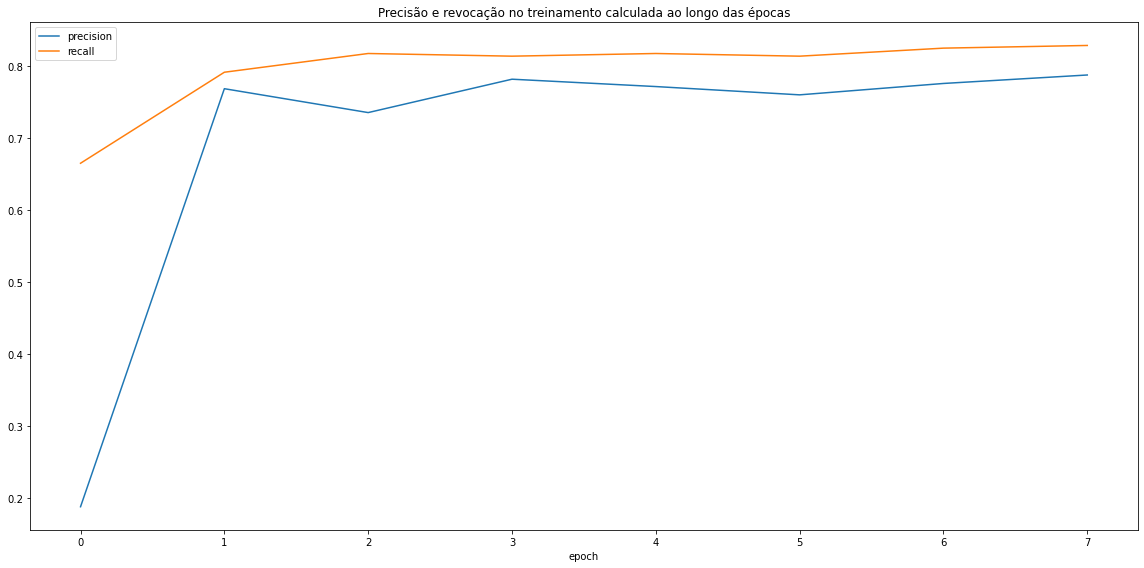

In [46]:
fig, axes = plt.subplots(
    figsize = (16,8)
    )

plt.plot(
    hist_b.history['precision_1'],
    label = 'precision'
    )
plt.plot(
    hist_b.history['recall_1'],
    label = 'recall'
    )

plt.title('Precisão e revocação no treinamento calculada ao longo das épocas')
plt.xlabel('epoch')
plt.legend(
    ['precision', 'recall'],
    loc = 'best'
    )
fig.tight_layout()
plt.show()

#### Exiba precisão e revocação calculada no treinamento S e teste T

In [47]:
# S
score = model_b.evaluate(
    S[0],
    S[1],
    verbose=0
    )
print("S - PRECISION: %.5f" % (score[1]))
print("S - RECALL: %.5f" % (score[2]))

S - PRECISION: 0.92308
S - RECALL: 0.96000


In [48]:
# T
score = model_b.evaluate(
    T[0],
    T[1],
    verbose=0
    )
print("T - PRECISION: %.5f" % (score[1]))
print("T - RECALL: %.5f" % (score[2]))

T - PRECISION: 0.64964
T - RECALL: 0.79821


#### Exiba um scatterplot do conjunto S obtendo sua representação do código da rede de classificação (saída da camada com 28 exemplos)

In [49]:
code_model = keras.models.Model(
    inputs = model_b.input,
    outputs = model_b.get_layer('code').output
    )

In [50]:
code_train = np.asarray(
    code_model.predict(
        S[0]
        )
    )

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not       Class
0         0
1         0
2         0
3         0
4         0
...     ...
7115      0
7116      0
7117      0
7118      0
7119      0

[7120 rows x 1 columns]

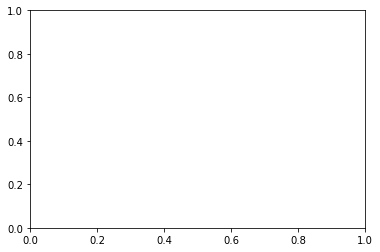

In [53]:
plt.scatter(
    code_train[:,0], code_train[:,1], c = S[1][:], cmap='viridis'
    )
plt.colorbar()

### Bônus: Tentando outros métodos para treinar com os poucos dados rotulados

#### Tentativa 1: DNN com a mesma arquitetura usada, mas sem pré-treinamento

In [54]:
#Inicializando as sementes
seed(1)
set_seed(2)

In [55]:
encoder_2 = keras.models.Model(
    inputs = model_a.input,
    outputs = model_a.get_layer(name = 'code').output
    )

In [56]:
new_2 = keras.models.Sequential()
new_2.add(
    keras.layers.Dense(
        1,
        activation = 'sigmoid',
        name = 'pred',
        input_shape = encoder_2.output_shape[1:]
        )
    )

model_c = keras.models.Model(
    inputs = encoder_2.input,
    outputs = new_2(encoder_2.output)
    )

In [57]:
model_c.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28)                112       
_________________________________________________________________
dense (Dense)                (None, 32)                928       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)              

In [58]:
batch_size = 16
epochs = 15

# class_weight = {
#     0: 0.1,
#     1: 0.9
#     }

In [59]:
x_train = S[0].astype('float32').values
y_train = S[1].astype('float32').values

In [60]:
# Taxa de aprendizado inicial de 0.001
# e com decaimento em todas as épocas exponencial a -0.3
def scheduler_c(epoch, lr):
    return np.round(lr * tf.math.exp(-0.3),4)    

In [61]:
callbacklr_c = keras.callbacks.LearningRateScheduler(
    scheduler_c
    )

In [62]:
model_c.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(
        lr = 0.001
        ),
    metrics = [
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
        ]
    )

In [63]:
hist_c = model_c.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ callbacklr_c ],
#     class_weight = class_weight,
    verbose = 1
    )

Epoch 1/15
445/445 [==============================] - 1s 3ms/step - loss: 2.5757e-04 - precision_2: 0.9200 - recall_2: 0.9200
Epoch 2/15
445/445 [==============================] - 1s 3ms/step - loss: 2.2239e-04 - precision_2: 0.9200 - recall_2: 0.9200
Epoch 3/15
445/445 [==============================] - 1s 3ms/step - loss: 2.4925e-04 - precision_2: 0.9200 - recall_2: 0.9200
Epoch 4/15
445/445 [==============================] - 1s 3ms/step - loss: 2.0718e-04 - precision_2: 0.9231 - recall_2: 0.9600
Epoch 5/15
445/445 [==============================] - 1s 3ms/step - loss: 2.1513e-04 - precision_2: 0.9200 - recall_2: 0.9200
Epoch 6/15
445/445 [==============================] - 1s 3ms/step - loss: 1.9851e-04 - precision_2: 0.9231 - recall_2: 0.9600
Epoch 7/15
445/445 [==============================] - 1s 3ms/step - loss: 1.7229e-04 - precision_2: 0.9231 - recall_2: 0.9600
Epoch 8/15
445/445 [==============================] - 1s 3ms/step - loss: 1.8915e-04 - precision_2: 0.9231 - recall_2:

In [64]:
# S
score = model_c.evaluate(
    S[0],
    S[1],
    verbose=0
    )
print("S - PRECISION: %.5f" % (score[1]))
print("S - RECALL: %.5f" % (score[2]))

S - PRECISION: 0.64865
S - RECALL: 0.96000


In [65]:
# T
score = model_c.evaluate(
    T[0],
    T[1],
    verbose=0
    )
print("T - PRECISION: %.5f" % (score[1]))
print("T - RECALL: %.5f" % (score[2]))

T - PRECISION: 0.24656
T - RECALL: 0.80269


#### Tentativa 2: SVM nos dados originais

In [94]:
x_train = S[0].astype('float32').values
y_train = S[1].astype('float32').values

In [95]:
x_test = T[0].astype('float32').values
y_test = T[1].astype('float32').values

In [96]:
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf = svm.SVC(
    C = 10, random_state = 1
    )

clf.fit(
    x_train, y_train
    )

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=10, random_state=1)

In [97]:
# TRAINMENTO S
y_pred = clf.predict(
    x_train
    )

print("S - PRECISION: %.5f" % precision_score(y_train, y_pred))
print("S - RECALL: %.5f" % recall_score(y_train, y_pred))

S - PRECISION: 1.00000
S - RECALL: 1.00000


In [98]:
# TRAINMENTO T
y_pred = clf.predict(
    x_test
    )

print("T - PRECISION: %.5f" % precision_score(y_test, y_pred))
print("T - RECALL: %.5f" % recall_score(y_test, y_pred))

T - PRECISION: 0.65385
T - RECALL: 0.15247


#### Classificador SVM treinado nos dados S obtendo sua representação do código da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [99]:
code_model = keras.models.Model(
    inputs = model_b.input,
    outputs = model_b.get_layer('code').output
    )

In [100]:
code_train = np.asarray(code_model.predict(S[0].astype('float32').values))
y_train = S[1].astype('float32').values

In [101]:
code_test = np.asarray(code_model.predict(T[0].astype('float32').values))
y_test = T[1].astype('float32').values

In [102]:
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

clf = svm.SVC(
    C = 10, random_state = 1
    )

clf.fit(
    code_train, y_train
    )

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=10, random_state=1)

In [103]:
# TRAINMENTO S
y_pred = clf.predict(
    code_train
    )

print("S - PRECISION: %.5f" % precision_score(y_train, y_pred))
print("S - RECALL: %.5f" % recall_score(y_train, y_pred))

S - PRECISION: 1.00000
S - RECALL: 0.96000


In [104]:
# TRAINMENTO T
y_pred = clf.predict(
    code_test
    )

print("T - PRECISION: %.5f" % precision_score(y_test, y_pred))
print("T - RECALL: %.5f" % recall_score(y_test, y_pred))

T - PRECISION: 0.81250
T - RECALL: 0.52466
